<a href="https://colab.research.google.com/github/zhz03/209_project_Blimp_modelling/blob/main/Code/color_segementation(Non_ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('drive/Shared drives/ECE 209: Blimp project /color_segementation')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['color_segementation(Non-ML).ipynb', 'balloon.jpg']

## image reading
- Read and convert to RGB

In [ ]:
import cv2

In [ ]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
print(len(flags))

274


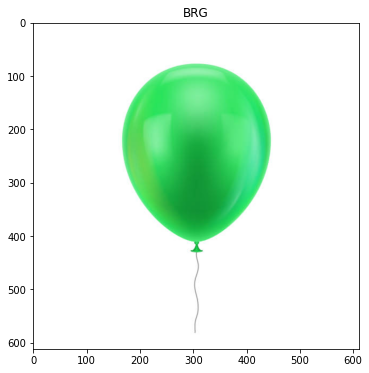

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
picture_location = 'drive/Shared drives/ECE 209: Blimp project /color_segementation/'
picture_name = 'balloon.jpg'
figure = cv2.imread(picture_location+picture_name)
fig = plt.figure(figsize=(6,6))
plt.imshow(figure)
plt.title('BRG')
plt.show()
## In OpenCv, figures are defaultly read in BGR format

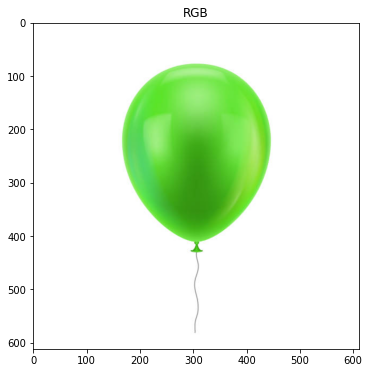

In [ ]:
## Transit it into RGB format
figure = cv2.cvtColor(figure, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(6,6))
plt.title('RGB')
plt.imshow(figure)
plt.show()

## RGB and HSV scattering

In [ ]:
print(figure.shape)

(612, 612, 3)


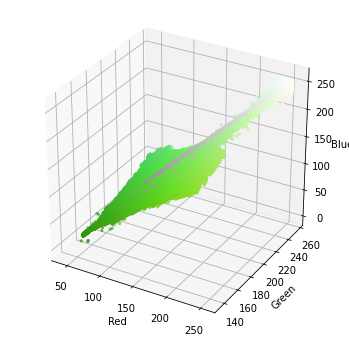

In [ ]:
## pixel scattering in RGB space
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
r, g, b = cv2.split(figure)
fig = plt.figure(figsize=(6,6))
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = figure.reshape((np.shape(figure)[0]*np.shape(figure)[1], np.shape(figure)[2]))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

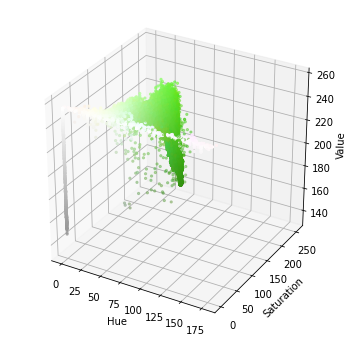

In [ ]:
## pixel scattering in HSV representation
figure_hsv = cv2.cvtColor(figure, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(figure_hsv)
fig = plt.figure(figsize=(6,6))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

## Segmentation (filtering)

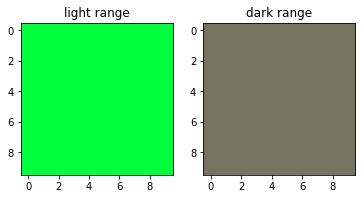

In [ ]:
from matplotlib.colors import hsv_to_rgb
## Define in HSV
## Transfer tool : https://toolstud.io/color/rgb.php
sensitivity = 30;
light_green = (65 + sensitivity, 255, 255)
dark_green = (65 - sensitivity, 50, 120)
light_sample = np.full((10, 10, 3), light_green, dtype=np.uint8) / 255.0
dark_sample = np.full((10, 10, 3), dark_green, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(light_sample))
plt.title('light range')
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(dark_sample))
plt.title('dark range')
plt.show()

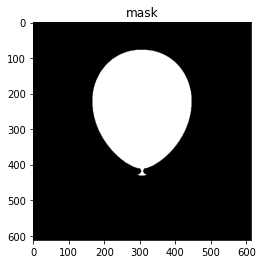

In [ ]:
mask = cv2.inRange(figure_hsv,dark_green,light_green)
plt.figure()
plt.imshow(mask, cmap="gray")
plt.title('mask')
plt.show()

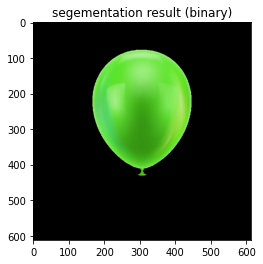

In [ ]:
result = cv2.bitwise_and(figure, figure, mask=mask)
plt.figure()
plt.imshow(result)
plt.title('segementation result (binary)')
plt.show()

## finding center

In [ ]:
result[(300,300)]

array([ 55, 151,  18], dtype=uint8)

In [ ]:
result[(1,1)]

array([0, 0, 0], dtype=uint8)

In [ ]:
(X, Y) = (result.shape[0],result.shape[1])
center_x = 0
center_y = 0
counts = 0
for x in range(X):
    for y in range(Y):
      if any(t1!=t2 for t1, t2 in zip(result[(x, y)], (0,0,0))): 
        center_x += x
        center_y += y
        counts += 1
center_x = center_x//counts
center_y = center_y//counts
print((center_x,center_y))
# equal = all(t1==t2 for t1, t2 in zip(result[(x, y)], (0,0,0)))

(236, 305)


## finding Centers of mulitple object

Require:
- Already finish segementation (binary or mulitple)

Method:
- Change segemented figure to grayscale figure
- Add Guassian bluring to smooth the grayscale figure
- Using threshold on blurred figure to find contours
- finding centers for each 'object'


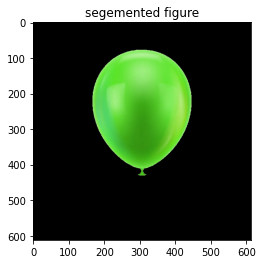

In [ ]:
plt.imshow(result)
plt.title('segemented figure')
plt.show()

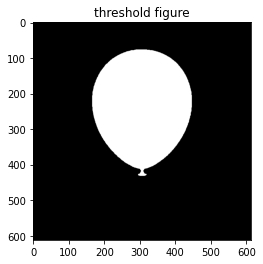

In [ ]:
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY)[1]
plt.figure()
plt.imshow(thresh,cmap='gray')
plt.title('threshold figure')
plt.show()

In [ ]:
import imutils
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

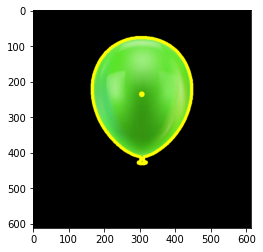

In [ ]:
# loop over the contours
marked_result = result.copy()
plt.figure()
for c in cnts:
	# compute the center of the contour
	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])
	# draw the contour and center of the shape on the image
	cv2.drawContours(marked_result, [c], -1, (255, 255, 0), 8)
	cv2.circle(marked_result, (cX, cY), 8, (255, 255, 0), -1)
	# cv2.putText(result, "center", (cX - 20, cY - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
	# show the result

plt.imshow(marked_result)
	# cv2.waitKey(0)
 